In [403]:
import networkx as nx
import math
import random
import numpy as np

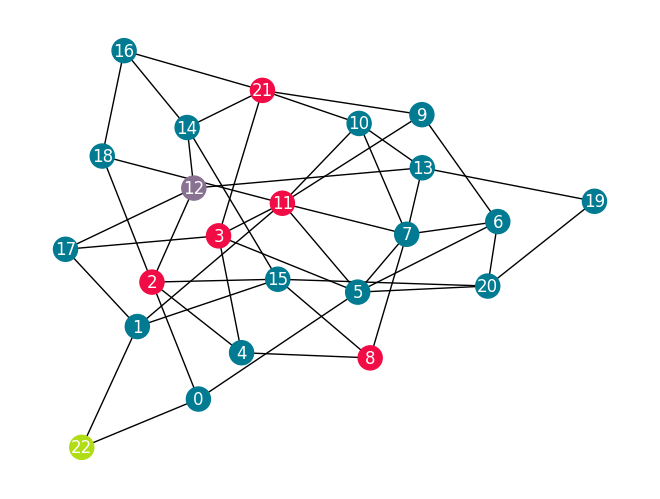

In [485]:
num_nodes = 23
G = nx.connected_watts_strogatz_graph(num_nodes, 4, 0.6, 10)

obstacle_upper_bound = num_nodes//3
num_obstacles = random.randrange(1, obstacle_upper_bound + 1)
obstacles = random.sample(range(num_nodes), num_obstacles)

graph_map = {node: node in obstacles if True else False for node in G}
# print(graph_map, obstacles)

potential_robot_positions = [node for node in graph_map if not graph_map[node]]
robot_goal_positions = random.sample(potential_robot_positions, k=2)
robot_pos, goal_pos = robot_goal_positions[0], robot_goal_positions[1]

for edge in G.edges:
    G.edges[edge]['pheromones'] = round(random.uniform(1e-3, 1e-2), 4)
    G.edges[edge]['weight'] = 1
# print(potential_robot_positions)

# for edge in G.edges:
#     print(G.edges[edge]['weight'])

# Draw the graph with individual node colors
colors = ['xkcd:pinkish red' if node in obstacles else 'xkcd:ocean' for node in graph_map]
colors[robot_pos] = 'xkcd:greyish purple'
colors[goal_pos] = 'xkcd:yellowish green'
nx.draw(G, with_labels=True, node_color=colors, font_color='white')

# pos = nx.spring_layout(G)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels

In [486]:
def traverse(
    g: nx.Graph,
    start_node: int,
    alpha: float,
    beta: float,
    end_of_the_line,
    saw
):
    path = [start_node]
    path_weight = 0
    visited = {start_node}
    u = start_node
    while len(visited) != len(g.nodes):

        # GOAL
        if u == goal_pos:
            print("Goal!", path)
            break

        neighbors_drmr = [v for v in g[u] if v not in obstacles]
        if len(neighbors_drmr) == 1 and u != start_node:
            saw[u] = 0
            print(u)
            break

        count = 0
        for v in neighbors_drmr:
            if saw[v] == 0:
                count += 1
        if count == len(neighbors_drmr)-1 and u != start_node:
            saw[u] = 0
            print(u)
            break
                
        neighbors = [v for v in g[u] if v not in visited and v not in obstacles and saw[v] != 0]
        if(len(neighbors) == 0):
            print("Death", path, path_weight)
            if len(path) > 1:
                end_of_the_line[path[-2]] *= 0.79
            end_of_the_line[u] = 0.13
            break
    
        values = ([g[u][v]['pheromones']**alpha / g[u][v]['weight']**beta *end_of_the_line[v] for v in neighbors], [v for v in neighbors])
        # 
        # if goal_pos in neighbors:
        #     chosen_neighbor = goal_pos
        # else:
        #     chosen_neighbor = random.choices(neighbors, weights=values, k=1)[0]
        chosen_neighbor = random.choices(neighbors, weights=values[0], k = 1)[0]
        # 
        # print(values, chosen_neighbor)
        path.append(chosen_neighbor)
        visited.add(chosen_neighbor)
        path_weight += g[u][chosen_neighbor]['weight']
        u = chosen_neighbor

    return path, path_weight

In [487]:
from matplotlib import pyplot as plt
from copy import deepcopy

In [488]:
def aco(
    g: nx.Graph,
    num_ants: int,
    rho: float,
    num_iters: int,
    theta: float,
    alpha: float,
    beta:float,
    end_of_the_line
):
    saw = [1 for _ in range(num_nodes)]
    best_cycle_lens = []
    final_cycle = None
    for i in range(num_iters):
        cycles = [traverse(g, start_node=robot_pos, alpha=alpha, beta=beta, end_of_the_line = end_of_the_line, saw = saw) for _ in range(num_ants)]
        
#       smanjivanje feromona - "isparavanje"
        for edge in g.edges:
            # G.edges[edge]['pheromones']
            g.edges[edge]['pheromones'] *= rho

#       dodavanje feromona
        for cycle, cycle_weight in cycles:
            delta = theta / (cycle_weight+1) # TODO za domaci theta se smanjuje kroz iteracije
            for u, v in zip(cycle[:-1], cycle[1:]):
                g[u][v]['pheromones'] += delta
            
        best_cycle = min(cycles, key=lambda c: c[1])
        best_cycle_lens.append(best_cycle[1])
        if final_cycle is None or best_cycle[1] < final_cycle[1]:
            final_cycle = deepcopy(best_cycle)
    
    plt.plot(range(num_iters), best_cycle_lens)
    print(final_cycle[0])
    print(final_cycle[1])

Goal! [12, 14, 15, 1, 22]
Death [12, 13, 10, 7, 5, 6, 20, 19] 7
Death [12, 13, 7, 6, 5, 20, 19] 6
18
16
Goal! [12, 13, 10, 7, 6, 5, 0, 22]
Death [12, 17, 1, 15, 14] 4
Goal! [12, 17, 1, 22]
Death [12, 13, 10, 7, 5, 6, 20, 15, 14] 8
Goal! [12, 13, 10, 7, 6, 20, 5, 0, 22]
9
Goal! [12, 13, 10, 7, 6, 5, 20, 15, 1, 22]
Death [12, 17, 1, 15, 20, 6, 5, 7, 10, 13, 19] 10
Goal! [12, 13, 10, 7, 6, 20, 5, 0, 22]
Goal! [12, 17, 1, 22]
Death [12, 13, 10, 7, 5, 6, 20, 15, 14] 8
Goal! [12, 17, 1, 22]
Death [12, 17, 1, 15, 14] 4
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 22]
Death [12, 13, 10, 7, 6, 20, 15, 14] 7
Death [12, 13, 7, 10] 3
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 22]
Goal! [12, 13, 7, 6, 5, 0, 22]
Goal! [12, 13, 10, 7, 6, 5, 0, 22]
Goal! [12, 13, 7, 5, 6, 20, 15, 1, 22]
Goal! [12, 13, 10, 7, 6, 20, 5, 0, 22]
Goal! [12, 17, 1, 22]
Goal! [12, 17, 1, 15, 20, 5, 0, 22]
Death [12, 13, 7, 6, 5, 20, 15, 1, 17] 8


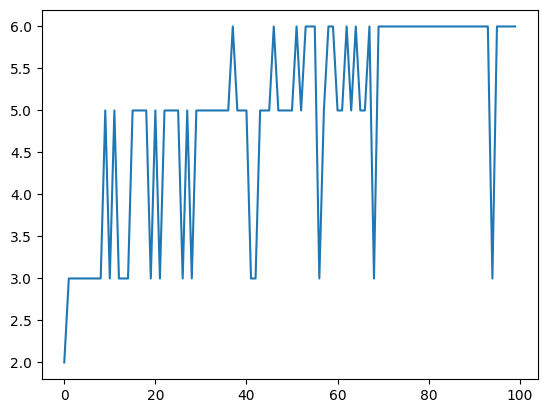

In [489]:
end_of_the_line = [1 for _ in range(num_nodes)]
aco(g=G, num_ants=10, rho=0.9, num_iters=100, alpha=0.9, beta=1.5, theta=100.0, end_of_the_line = end_of_the_line)